In [2]:
# ====================================
# 0. Install Required Libraries
# ====================================
# pip install torch torchvision timm scikit-learn tqdm

import os
import glob
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import timm
from sklearn.model_selection import train_test_split

In [4]:
# ====================================
# 1. Load Dataset
# ====================================
root_path = 'cattle_dataset'
val_split = 0.2

all_data = []
class_names = sorted(os.listdir(root_path))
label_map = {name: idx for idx, name in enumerate(class_names)}

for class_name in class_names:
    class_path = os.path.join(root_path, class_name)
    if os.path.isdir(class_path):
        for img_path in glob.glob(os.path.join(class_path, '*.jpg')):
            all_data.append((img_path, label_map[class_name]))

train_data, val_data = train_test_split(
    all_data,
    test_size=val_split,
    stratify=[x[1] for x in all_data],
    random_state=42
)
num_classes = len(label_map)


In [6]:
# ====================================
# 2. Define Transformations
# ====================================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [8]:
# ====================================
# 3. Prepare Dataset and DataLoader
# ====================================
class SimpleDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

train_loader = DataLoader(SimpleDataset(train_data, transform), batch_size=32, shuffle=True)
val_loader = DataLoader(SimpleDataset(val_data, transform), batch_size=32)

In [10]:
# ====================================
# 4. Define Model (MHAFF)
# ====================================
cnn = timm.create_model('efficientnetv2_s', pretrained=False, num_classes=0)
vit = timm.create_model('vit_small_patch16_224', pretrained=False, num_classes=0)

dim_cnn = cnn.num_features
dim_vit = vit.num_features
embed_dim = dim_cnn + dim_vit

mha = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=8, batch_first=True)
classifier = nn.Sequential(
    nn.LayerNorm(embed_dim),
    nn.Linear(embed_dim, num_classes)
)
pos_emb = nn.Parameter(torch.zeros(1, 1, embed_dim))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn.to(device)
vit.to(device)
mha.to(device)
classifier.to(device)
pos_emb = pos_emb.to(device)

In [12]:
# ====================================
# 5. Loss & Optimizer
# ====================================
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    list(cnn.parameters()) +
    list(vit.parameters()) +
    list(mha.parameters()) +
    list(classifier.parameters()) +
    [pos_emb], lr=1e-4)

In [14]:
# ====================================
# 6. Training Loop
# ====================================
best_acc = 0

for epoch in range(1, 31):
    cnn.train(), vit.train(), mha.train(), classifier.train()
    total_loss, correct = 0.0, 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch} - Training"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        f_cnn = cnn(x)  # (B, C)
        f_vit = vit(x)  # (B, V)
        fused = torch.cat([f_cnn, f_vit], dim=1).unsqueeze(1) + pos_emb  # (B, 1, C+V)
        attn_out, _ = mha(fused, fused, fused)
        out = classifier(attn_out.squeeze(1))

        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()

    train_acc = correct / len(train_loader.dataset)
    avg_loss = total_loss / len(train_loader)

    # Evaluation
    cnn.eval(), vit.eval(), mha.eval(), classifier.eval()
    correct = 0

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc=f"Epoch {epoch} - Validation"):
            x, y = x.to(device), y.to(device)
            f_cnn = cnn(x)
            f_vit = vit(x)
            fused = torch.cat([f_cnn, f_vit], dim=1).unsqueeze(1) + pos_emb
            attn_out, _ = mha(fused, fused, fused)
            out = classifier(attn_out.squeeze(1))
            correct += (out.argmax(1) == y).sum().item()

    val_acc = correct / len(val_loader.dataset)
    print(f"Epoch {epoch}: Train Loss = {avg_loss:.4f}, Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'cnn': cnn.state_dict(),
            'vit': vit.state_dict(),
            'mha': mha.state_dict(),
            'classifier': classifier.state_dict(),
            'pos_emb': pos_emb
        }, 'best_mhaff.pth')

print(f"Best Validation Accuracy: {best_acc:.4f}")


Epoch 1 - Validation: 100%|█████████████████████| 31/31 [02:40<00:00,  5.18s/it]


Epoch 1: Train Loss = 4.1587, Train Acc = 0.1072, Val Acc = 0.1746


Epoch 2 - Validation: 100%|█████████████████████| 31/31 [02:59<00:00,  5.78s/it]


Epoch 2: Train Loss = 2.9588, Train Acc = 0.2519, Val Acc = 0.3178


Epoch 3 - Validation: 100%|█████████████████████| 31/31 [03:15<00:00,  6.30s/it]


Epoch 3: Train Loss = 2.0685, Train Acc = 0.4467, Val Acc = 0.5360


Epoch 4 - Validation: 100%|█████████████████████| 31/31 [02:25<00:00,  4.71s/it]


Epoch 4: Train Loss = 1.4660, Train Acc = 0.6166, Val Acc = 0.6508


Epoch 5 - Validation: 100%|█████████████████████| 31/31 [02:23<00:00,  4.63s/it]


Epoch 5: Train Loss = 1.0217, Train Acc = 0.7346, Val Acc = 0.8162


Epoch 6 - Validation: 100%|█████████████████████| 31/31 [02:43<00:00,  5.28s/it]


Epoch 6: Train Loss = 0.6874, Train Acc = 0.8344, Val Acc = 0.8731


Epoch 7 - Validation: 100%|█████████████████████| 31/31 [11:43<00:00, 22.70s/it]


Epoch 7: Train Loss = 0.5305, Train Acc = 0.8771, Val Acc = 0.8853


Epoch 8 - Validation: 100%|█████████████████████| 31/31 [02:48<00:00,  5.45s/it]


Epoch 8: Train Loss = 0.3484, Train Acc = 0.9220, Val Acc = 0.8670


Epoch 9 - Validation: 100%|█████████████████████| 31/31 [02:34<00:00,  4.98s/it]


Epoch 9: Train Loss = 0.3068, Train Acc = 0.9297, Val Acc = 0.9371


Epoch 10 - Validation: 100%|████████████████████| 31/31 [02:55<00:00,  5.67s/it]


Epoch 10: Train Loss = 0.2309, Train Acc = 0.9535, Val Acc = 0.9614


Epoch 11 - Validation: 100%|████████████████████| 31/31 [02:16<00:00,  4.39s/it]


Epoch 11: Train Loss = 0.1848, Train Acc = 0.9627, Val Acc = 0.9553


Epoch 12 - Validation: 100%|████████████████████| 31/31 [02:32<00:00,  4.92s/it]


Epoch 12: Train Loss = 0.1238, Train Acc = 0.9777, Val Acc = 0.9198


Epoch 13 - Validation: 100%|████████████████████| 31/31 [02:37<00:00,  5.09s/it]


Epoch 13: Train Loss = 0.2397, Train Acc = 0.9474, Val Acc = 0.9320


Epoch 14 - Validation: 100%|████████████████████| 31/31 [02:17<00:00,  4.43s/it]


Epoch 14: Train Loss = 0.1832, Train Acc = 0.9596, Val Acc = 0.9168


Epoch 15 - Validation: 100%|████████████████████| 31/31 [02:40<00:00,  5.19s/it]


Epoch 15: Train Loss = 0.2043, Train Acc = 0.9533, Val Acc = 0.9584


Epoch 16 - Validation: 100%|████████████████████| 31/31 [02:55<00:00,  5.65s/it]


Epoch 16: Train Loss = 0.1697, Train Acc = 0.9639, Val Acc = 0.9330


Epoch 17 - Validation: 100%|████████████████████| 31/31 [02:48<00:00,  5.44s/it]


Epoch 17: Train Loss = 0.1794, Train Acc = 0.9622, Val Acc = 0.9675


Epoch 18 - Validation: 100%|████████████████████| 31/31 [02:44<00:00,  5.31s/it]


Epoch 18: Train Loss = 0.1652, Train Acc = 0.9622, Val Acc = 0.9675


Epoch 19 - Validation: 100%|████████████████████| 31/31 [02:52<00:00,  5.57s/it]


Epoch 19: Train Loss = 0.1513, Train Acc = 0.9685, Val Acc = 0.9553


Epoch 20 - Validation: 100%|████████████████████| 31/31 [03:14<00:00,  6.29s/it]


Epoch 20: Train Loss = 0.1241, Train Acc = 0.9749, Val Acc = 0.9350


Epoch 21 - Validation: 100%|████████████████████| 31/31 [02:22<00:00,  4.58s/it]


Epoch 21: Train Loss = 0.1228, Train Acc = 0.9695, Val Acc = 0.9635


Epoch 22 - Validation: 100%|████████████████████| 31/31 [08:55<00:00, 17.29s/it]


Epoch 22: Train Loss = 0.0532, Train Acc = 0.9881, Val Acc = 0.9624


Epoch 23 - Validation: 100%|████████████████████| 31/31 [02:15<00:00,  4.38s/it]


Epoch 23: Train Loss = 0.1301, Train Acc = 0.9693, Val Acc = 0.9614


Epoch 24 - Validation: 100%|████████████████████| 31/31 [02:29<00:00,  4.82s/it]


Epoch 24: Train Loss = 0.0405, Train Acc = 0.9931, Val Acc = 0.9726


Epoch 25 - Validation: 100%|████████████████████| 31/31 [02:32<00:00,  4.93s/it]


Epoch 25: Train Loss = 0.0675, Train Acc = 0.9843, Val Acc = 0.9746


Epoch 26 - Validation: 100%|████████████████████| 31/31 [02:23<00:00,  4.64s/it]


Epoch 26: Train Loss = 0.0423, Train Acc = 0.9914, Val Acc = 0.9695


Epoch 27 - Validation: 100%|████████████████████| 31/31 [02:36<00:00,  5.03s/it]


Epoch 27: Train Loss = 0.0952, Train Acc = 0.9774, Val Acc = 0.9645


Epoch 28 - Validation: 100%|████████████████████| 31/31 [02:40<00:00,  5.19s/it]


Epoch 28: Train Loss = 0.0786, Train Acc = 0.9853, Val Acc = 0.9604


Epoch 29 - Validation: 100%|████████████████████| 31/31 [02:46<00:00,  5.36s/it]


Epoch 29: Train Loss = 0.2076, Train Acc = 0.9459, Val Acc = 0.9584


Epoch 30 - Validation: 100%|████████████████████| 31/31 [03:00<00:00,  5.81s/it]

Epoch 30: Train Loss = 0.1035, Train Acc = 0.9787, Val Acc = 0.9624
Best Validation Accuracy: 0.9746


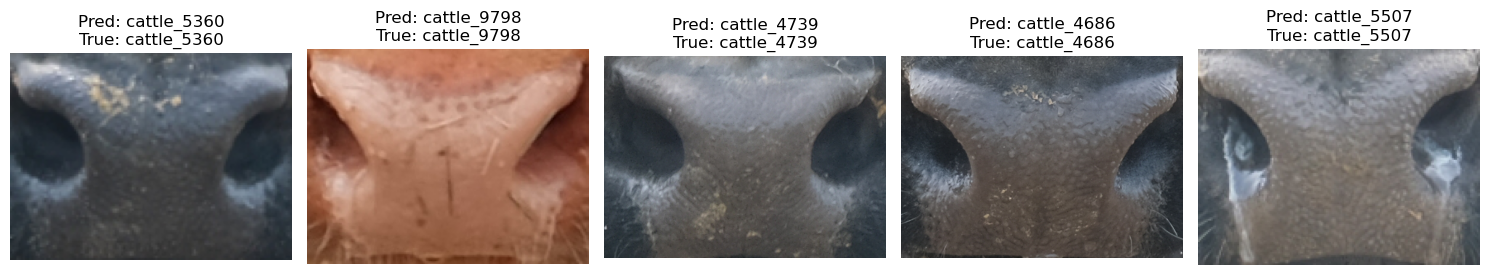

In [18]:
# ====================================
# 7. Test & Show Predictions
# ====================================
# Load saved state dicts
checkpoint = torch.load('best_mhaff.pth', map_location=device)
cnn.load_state_dict(checkpoint['cnn'])
vit.load_state_dict(checkpoint['vit'])
mha.load_state_dict(checkpoint['mha'])
classifier.load_state_dict(checkpoint['classifier'])
pos_emb = checkpoint['pos_emb'].to(device)

cnn.eval(), vit.eval(), mha.eval(), classifier.eval()

# Get class name mapping (idx to label)
idx_to_class = {v: k for k, v in label_map.items()}

# Test on a few validation images
import matplotlib.pyplot as plt

n_samples = 5
samples = val_data[:n_samples]

plt.figure(figsize=(15, 5))
for i, (img_path, label) in enumerate(samples):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        f_cnn = cnn(img_tensor)
        f_vit = vit(img_tensor)
        fused = torch.cat([f_cnn, f_vit], dim=1).unsqueeze(1) + pos_emb
        attn_out, _ = mha(fused, fused, fused)
        out = classifier(attn_out.squeeze(1))
        pred = out.argmax(1).item()

    plt.subplot(1, n_samples, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Pred: {idx_to_class[pred]}\nTrue: {idx_to_class[label]}")
plt.tight_layout()
plt.show()
